In [20]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_metric
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import nltk
import contractions
import matplotlib.pyplot as plt

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

- The dataset is taken from the following [link](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

In [22]:
df = pd.read_csv("../Data/Suicide_Detection.csv",index_col=0)
df.reset_index(drop=True, inplace=True)
df = df.dropna()
df.head()

,text,class
0,Can we talk?,non-suicide
1,Give me the plan to talk please.,non-suicide
2,I tried to talk with him. He did not co-operat...,non-suicide
3,Ex Wife Threatening SuicideRecently I left my ...,suicide
4,Am I weird I don't get affected by compliments...,non-suicide


In [23]:
# check the number of empty rows.
print(df['text'].apply(lambda x: x == '').sum())
# remove the empty rows
df = df[df['text'].apply(lambda x: len(x.split())!=0)]

0


<Axes: >

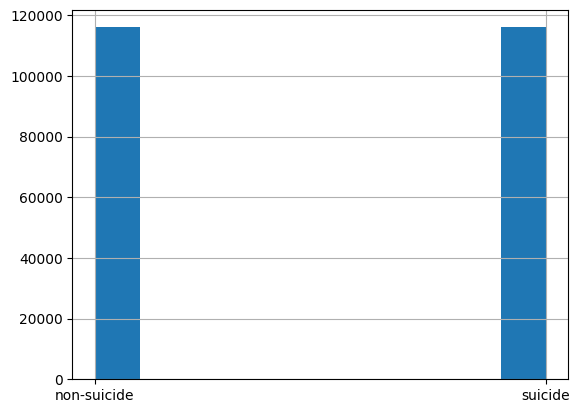

In [24]:
df['class'].hist()

### Preprocessing the dataset.
- The dataset must have the label column named as 'label', to be trained using Trainer API. It is preferable to keep the text column as 'text'. Since we tokenise text column, it can be named anything, as we just pass the tokenised columns input_ids and attention_mask to the model.

In [25]:
# Text normalization and cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

def clean_text(text):
    try:
        text = contractions.fix(text)  # remove contractions such as haven't to have not
    except:
        pass
    text = text.lower()  # convert text to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'https?://\S+|www\.\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove accented characters such as cafe`
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emojis
    text = re.sub(r'(\w)\1{2,}', r'\1', text)  # Remove consecutive repeated characters if repeated 3 or more times
    text = re.sub(r'\W', ' ', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra white spaces
    word_tokens = word_tokenize(text)  # tokenize text
    filtered_text = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]  # remove stopwords and lemmatize
    return ' '.join(filtered_text)

def clean_text_light(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'https?://\S+|www\.\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove accented characters such as cafe`
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emojis
    text = re.sub(r'\s+', ' ', text)  # remove extra white spaces
    return text


In [26]:
df['text'] = df['text'].apply(clean_text_light)
# rename the column class to label
df.rename(columns={'class': 'label'}, inplace=True)

# encoder = LabelEncoder()
# df['label'] = encoder.fit_transform(df['class'])

In [27]:
# check the number of empty rows.
print(df['text'].apply(lambda x: x == '').sum())
# remove the empty rows
df = df[df['text'].apply(lambda x: len(x.split())!=0)]

2


In [28]:
df.head()
df.to_csv('../Data/Suicide_Detection_Cleaned_light.csv', index=False)

In [29]:
dataset = Dataset.from_pandas(df)
dataset= dataset.remove_columns("__index_level_0__")


In [30]:
# remove conversation with more than 1024 tokens, for training memory reasons.
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
dataset = dataset.map(lambda x: {"input_ids_length": len(tokenizer(x["text"])[0])})
# filter out the samples that are too long
max_input_length = 512
dataset = dataset.filter(lambda x: x["input_ids_length"] <= max_input_length)
dataset = dataset.remove_columns(["input_ids_length"])
print(dataset)

Filter: 100%|██████████| 232038/232038 [00:01<00:00, 229900.48 examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 218495
})


In [31]:
dataset = dataset.train_test_split(test_size=0.3)
val_split = dataset['test']
val_split = val_split.train_test_split(test_size=0.5)
train_test_val_split = DatasetDict({
    "train": dataset['train'],
    "test": val_split['train'],
    "val": val_split['test']
})
print(train_test_val_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 152946
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 32774
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32775
    })
})


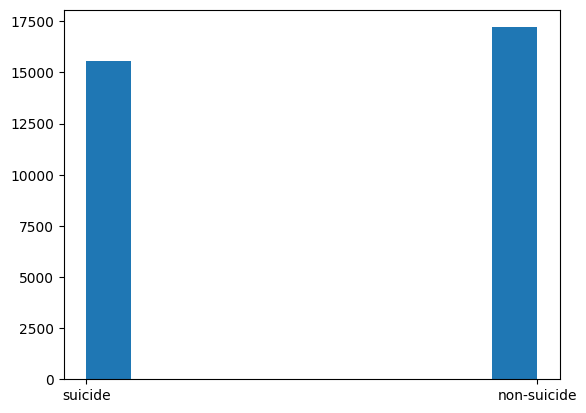

In [32]:
plt.hist(np.array(train_test_val_split['val']['label']))
plt.show()

In [33]:
train_test_val_split.push_to_hub("phr_suicide_prediction_dataset_clean_light")

Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/vibhorag101/phr_suicide_prediction_dataset_clean_light/commit/72f033570b7a35bf035e715cf55402b4be76a1fa', commit_message='Upload dataset', commit_description='', oid='72f033570b7a35bf035e715cf55402b4be76a1fa', pr_url=None, pr_revision=None, pr_num=None)